In [7]:
import pynq
from pynq import Overlay
from pynq import MMIO
import time
from operator import*
import matplotlib.pyplot as plt

In [8]:
# Load the SPI overlay
ol = Overlay("spi.bit")
spi = ol.axi_quad_spi_0

In [9]:
def init(spi, phase=0, polarity=0):
    spi.write(0x40, 0x0a)
    spi.write(0x28, 0x04)
    spi.write(0x1c, 0)
    spi.write(0x70, 0xFFFFFFFF)
    ctrlreg = spi.read(0x60)
    ctrlreg = ctrlreg | 0xe6
    spi.write(0x60, ctrlreg)
    ctrlreg = spi.read(0x60)
    ctrlreg = ctrlreg & ~(0x18) 
    if phase == 1:
        ctrlreg = ctrlreg | 0x10
    if polarity == 1:
        ctrlreg = ctrlreg | 0x08
    spi.write(0x60, ctrlreg)

In [10]:
def transfer(packet, spi):
    for data in packet:
        spi.write(0x68, data)
        spi.write(0x70, 0xFFFFFFFE)
        ctrlreg = spi.read(0x60)
        ctrlreg = ctrlreg & ~(0x100)
        spi.write(0x60, ctrlreg)
        statReg = spi.read(0x64)
        while (statReg & 0x04) == 0:
            statReg = spi.read(0x64)
        ctrlreg = spi.read(0x60)
        ctrlreg = ctrlreg | 0x100
        spi.write(0x60, ctrlreg)
    spi.write(0x70, 0xFFFFFFFF)
    recvData = list()
    RxFifoStatus = spi.read(0x64) & 0x01
    while RxFifoStatus == 0:
        temp = spi.read(0x6c)
        recvData.append(temp)
        RxFifoStatus = spi.read(0x64) & 0x01
    return recvData

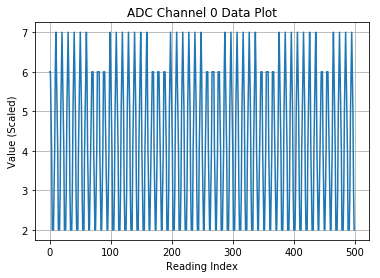

In [15]:
init(spi)
values_channel_0 = []  # List to store Channel 0 readings
for i in range (500):
    sendData = transfer([128+i, i*i+2], spi)
    recvData = transfer([i], spi)
    values_channel_0.append(recvData)
    time.sleep(0.1)
    
    
    

# Plot the collected data
plt.plot(values_channel_0)
plt.title('ADC Channel 0 Data Plot')
plt.xlabel('Reading Index')
plt.ylabel('Value (Scaled)')
plt.grid(True)
plt.show()

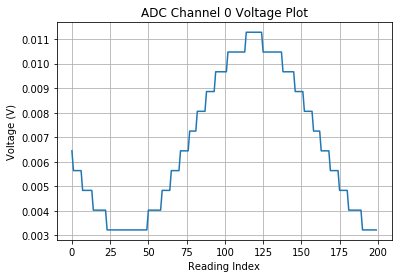

In [19]:
# Initialize SPI with correct phase/polarity for the ADC
init(spi, phase=1, polarity=1)  # Modify based on the ADC requirements

values_channel_0 = []  # List to store Channel 0 readings
for i in range(200):  # Increase the number of readings
    sendData = transfer([128+i, i*i+2], spi)  # Send dummy data
    recvData = transfer([0], spi)  # Read data (Channel 0)
    values_channel_0.append(recvData[0])  # Append the first received value
    time.sleep(0.005)  # Shorten delay for faster sampling

# Assuming a 12-bit ADC with 3.3V reference voltage
V_ref = 3.3
resolution = 4096  # 2^12 for 12-bit ADC

scaled_values = [value * V_ref / resolution for value in values_channel_0]

# Plot the scaled data
plt.plot(scaled_values)
plt.title('ADC Channel 0 Voltage Plot')
plt.xlabel('Reading Index')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()
